
# ETL com DummyJSON (online) — Users & Carts

Este notebook implementa um **pipeline ETL** consumindo dados **online** do [DummyJSON](https://dummyjson.com/).
Ele baixa **/users** e **/carts**, salva **cada registro como um arquivo JSON (nomeado pelo `id`)** na pasta do projeto,
transforma e integra os dados, e carrega em formatos analíticos (CSV/Parquet/SQLite).

> Endpoints usados:  
> • `GET https://dummyjson.com/users` (lista de usuários, campos com `id`)  
> • `GET https://dummyjson.com/carts` (carrinhos, com `userId` para junção)



## 1) Bibliotecas e versões

- **`requests`** — chamadas HTTP aos endpoints do DummyJSON  
- **`pandas`** — normalização, limpeza, join e exportação  
- **`pyarrow`** — suporte opcional para gravar Parquet via `pandas`  
- **`sqlite3`** — banco leve para *staging/analytics*  
- **`json` / `pathlib` / `glob`** — E/S de arquivos JSON e manipulação de caminhos  
- **`matplotlib`** — visualização rápida (ex.: gasto total por usuário)

### Instalação (terminal)
```bash
pip install requests pandas pyarrow matplotlib
```

**Para quê?**
A biblioteca **`requests`** é usada para **interagir programaticamente com serviços web** através do protocolo HTTP. Ela abstrai os detalhes de baixo nível da comunicação (sockets, codificação, tratamento de cabeçalhos) e oferece uma interface simples para:

* **Enviar requisições** em diferentes verbos HTTP (`GET`, `POST`, `PUT`, `DELETE`, etc.).
* **Personalizar parâmetros e cabeçalhos** (`params`, `headers`, `cookies`, autenticação).
* **Enviar e receber dados estruturados** (JSON, XML, formulários).
* **Gerenciar erros e respostas** com métodos como `raise_for_status()`.
* **Tratar sessões persistentes** (armazenando cookies e autenticação em múltiplas requisições).
* **Controle de timeout e retries**, útil em pipelines de dados.

No contexto de ETL, o `requests` é geralmente usado para **extrair dados de APIs** (como DummyJSON) e transformá-los em objetos Python que podem ser processados ou persistidos.

**Exemplo prático**:

In [1]:
import requests

url = "https://dummyjson.com/users/1"
resp = requests.get(url, timeout=30)
resp.raise_for_status()           # lança erro se HTTP 4xx/5xx
data = resp.json()                # dict Python a partir do JSON
print(data["firstName"], data["lastName"])

Emily Johnson


In [4]:
import requests

# endpoint de usuários
url = "https://dummyjson.com/users"

# GET com parâmetros
resp = requests.get(url,params={"limit": 3},timeout=10)

# verifica se a requisição foi bem-sucedida
resp.raise_for_status()

# transforma JSON em dict/list Python
dados = resp.json()

for user in dados["users"]:
    print(f"{user['id']}: {user['firstName']} {user['lastName']}")

1: Emily Johnson
2: Michael Williams
3: Sophia Brown


### `pandas` — análise e transformação tabular

**Para quê?**
A biblioteca **`pandas`** é um dos pilares da ciência de dados em Python. Ela fornece estruturas de dados eficientes (`Series` e `DataFrame`) para **representar e manipular dados tabulares**, funcionando como uma espécie de “Excel programável”. Com ela é possível:

* **Ler e escrever** dados em diversos formatos (CSV, JSON, Excel, SQL, Parquet, etc.).
* **Normalizar e limpar** dados brutos (remover nulos, renomear colunas, converter tipos).
* **Realizar operações estatísticas** e agregações (`mean`, `sum`, `count`, etc.).
* **Transformar e combinar** dados com `merge`, `join`, `concat`, `pivot` e `groupby`.
* **Selecionar e filtrar** linhas e colunas de forma intuitiva (`loc`, `iloc`, máscaras lógicas).
* **Exportar** resultados em formatos otimizados (CSV para portabilidade, Parquet para performance).

No contexto de ETL, o `pandas` atua principalmente na fase de **T (Transform)**, preparando os dados para análises ou carregamento em outro sistema.

**Exemplo básico**:

In [5]:
import pandas as pd

registros = [{"userId": 1, "total": 100.0}, {"userId": 2, "total": 50.5}, {"userId": 1, "total": 25.0}]
df = pd.DataFrame(registros)
print(df.groupby("userId")["total"].sum())  # soma por usuário

userId
1    125.0
2     50.5
Name: total, dtype: float64


In [6]:
import pandas as pd

# dados brutos (poderiam ter vindo de um JSON)
registros = [
    {"userId": 1, "total": 100.0},
    {"userId": 2, "total": 50.5},
    {"userId": 1, "total": 25.0},
]

# cria DataFrame
df = pd.DataFrame(registros)

# agrega: soma o total por usuário
resumo = df.groupby("userId")["total"].sum().reset_index()

print(resumo)

   userId  total
0       1  125.0
1       2   50.5


### `pyarrow` — suporte a Parquet/Arrow (opcional no pandas)

**Para quê?**
A biblioteca **`pyarrow`** é a implementação Python do **Apache Arrow**, um formato de dados colunar em memória projetado para **alto desempenho e interoperabilidade entre sistemas de análise**. Dentro de um pipeline ETL, ela é usada principalmente para:

* **Serialização e desserialização em formatos eficientes** como **Parquet** e **Feather**, reduzindo espaço em disco e acelerando leitura/escrita.
* **Conversão entre pandas DataFrames e tabelas Arrow**, preservando tipos e otimizando operações de I/O.
* **Interoperabilidade** com outros ecossistemas de Big Data (Spark, Dask, Hadoop, etc.) graças ao padrão Arrow.
* **Manipulação de dados em memória** de forma colunar, o que melhora a performance de operações vetorizadas.

O `pandas` delega a gravação em Parquet para bibliotecas externas como `pyarrow` ou `fastparquet`. Por isso, instalar `pyarrow` é recomendado sempre que o fluxo de ETL envolve **arquivos grandes ou integração com sistemas analíticos**.

**Exemplo básico (via pandas)**:

In [ ]:
import pandas as pd
df = pd.DataFrame({"userId":[1,2], "total":[125.0, 50.5]})
df.to_parquet("out.parquet", index=False)   # requer pyarrow instalado

In [ ]:
import pandas as pd

df = pd.DataFrame({
    "userId": [1, 2],
    "total": [125.0, 50.5]
})

# grava DataFrame em formato Parquet (compacto e otimizado)
df.to_parquet("out.parquet", engine="pyarrow", index=False)

# lê de volta
novo_df = pd.read_parquet("out.parquet")
print(novo_df)

**Exemplo direto com PyArrow**:

In [ ]:
import pyarrow as pa
import pyarrow.parquet as pq

# cria tabela Arrow a partir de um DataFrame pandas
table = pa.Table.from_pandas(df)

# grava em Parquet
pq.write_table(table, "out_direct.parquet")

# lê de volta
parquet_file = pq.ParquetFile("out_direct.parquet")
print(parquet_file.metadata)

### `sqlite3` — banco SQL embutido (staging/analytics leve)

**Para quê?**
O módulo **`sqlite3`** (parte da biblioteca padrão do Python) provê uma interface para o **SQLite**, um banco de dados relacional leve, embutido em um único arquivo `.db`. Ele não exige servidor separado, sendo ideal para pipelines ETL em que se deseja:

* **Persistir dados localmente** durante a fase de *staging* (pré-análise) sem depender de sistemas externos.
* **Executar consultas SQL completas** (JOINs, agregações, subqueries, etc.) para transformação e análise.
* **Integrar com pandas**, exportando/importando dados diretamente de/para DataFrames.
* **Trabalhar com portabilidade**: basta distribuir o arquivo `.db` para replicar o dataset.
* **Testar protótipos** antes de migrar para um banco mais robusto (PostgreSQL, MySQL, etc.).

No fluxo ETL, o `sqlite3` é usado como **área intermediária (staging)** para organizar e validar dados antes de carregá-los em um data warehouse ou ferramenta analítica.

[Documentação oficial do módulo sqlite3 (Python)](https://docs.python.org/3/library/sqlite3.html)
[Documentação do SQLite](https://www.sqlite.org/docs.html)

**Exemplo básico**:

In [7]:
import sqlite3
import pandas as pd

# cria (ou abre) banco local
con = sqlite3.connect("staging.db")

# cria DataFrame (simulando dados de carrinhos de compra)
df = pd.DataFrame({
    "userId": [1, 2, 1],
    "total": [100.0, 50.5, 25.0]
})

# grava DataFrame em uma tabela SQL
df.to_sql("carts", con, if_exists="replace", index=False)

# consulta SQL: gasto total por usuário
resumo = pd.read_sql("""
    SELECT userId, SUM(total) AS total
    FROM carts
    GROUP BY userId
""", con)

print(resumo)

con.close()

   userId  total
0       1  125.0
1       2   50.5


### `json` / `pathlib` / `glob` — E/S de arquivos e caminhos

**Para quê?**

* **`json`**:

  * Serializa (`dump`, `dumps`) objetos Python (dict/list) em texto JSON.
  * Desserializa (`load`, `loads`) strings ou arquivos JSON em estruturas Python.
  * Útil em pipelines ETL para gravar dados intermediários ou consumir respostas de APIs.
  * [Documentação oficial](https://docs.python.org/3/library/json.html)

* **`pathlib`**:

  * Fornece uma API **orientada a objetos** para manipulação de caminhos de arquivos e diretórios.
  * Facilita operações multiplataforma (Windows, Linux, macOS) sem se preocupar com barras invertidas/duplas.
  * Permite criar pastas (`mkdir`), concatenar caminhos (`/`), ler/escrever arquivos diretamente (`write_text`, `read_text`).
  * [Documentação oficial](https://docs.python.org/3/library/pathlib.html)

* **`glob`**:

  * Faz busca de arquivos com **padrões de nomeação** (ex.: `*.json`, `**/*.parquet`).
  * Útil para varrer diretórios de *landing* ou *staging* e aplicar ETL em lote.
  * Trabalha integrado com `pathlib` para recuperar e manipular coleções de arquivos.
  * [Documentação oficial](https://docs.python.org/3/library/glob.html)

No contexto ETL, esse trio cobre a **camada de persistência em arquivos**: salvar dados em JSON, navegar na estrutura de diretórios e iterar sobre conjuntos de arquivos de forma eficiente e multiplataforma.

**Exemplo básico**:

In [ ]:
from pathlib import Path
import json, glob

# define pasta de dados
data_dir = Path("data")
data_dir.mkdir(exist_ok=True)

# salva um dicionário em JSON
payload = {"id": 1, "name": "Alice"}
(data_dir / "1.json").write_text(
    json.dumps(payload, ensure_ascii=False, indent=2),
    encoding="utf-8"
)

# percorre todos os arquivos JSON na pasta
for path in glob.glob(str(data_dir / "*.json")):
    obj = json.loads(Path(path).read_text(encoding="utf-8"))
    print(path, "->", obj["name"])

Esse conjunto cobre operações típicas de **E/S de arquivos no ETL**:

1. **`json`** garante interoperabilidade dos dados.
2. **`pathlib`** organiza diretórios de *landing* e *staging*.
3. **`glob`** permite iterar sobre arquivos em lote para transformações e carregamento.

### `matplotlib` — visualização rápida

**Para quê?**
A biblioteca **`matplotlib`** é a base da visualização científica em Python. Ela permite **construir gráficos estáticos, animados e interativos**, com controle detalhado sobre todos os elementos visuais. Mesmo que existam bibliotecas de mais alto nível (`seaborn`, `plotly`), o `matplotlib` continua sendo a “camada fundamental” usada nos bastidores.

Em um fluxo ETL, sua principal função é a etapa de **A (Analytics/Visualization)**, possibilitando:

* **Criar gráficos básicos**: barras, linhas, dispersão, histogramas.
* **Customizar estilos**: cores, eixos, rótulos, títulos, legendas, escalas logarítmicas.
* **Integrar com pandas**: DataFrames podem chamar diretamente `.plot()` para gerar gráficos rápidos.
* **Salvar visualizações** em formatos como PNG, PDF e SVG para relatórios.
* **Exploração ad-hoc** de dados transformados antes de carregá-los em relatórios mais robustos (Power BI, Tableau).

[Documentação oficial](https://matplotlib.org/stable/gallery/index.html)

**Exemplo básico**:

In [ ]:
import matplotlib.pyplot as plt

usuarios = ["u1", "u2", "u3"]
totais = [125.0, 50.5, 80.0]

plt.bar(usuarios, totais, color="skyblue")
plt.title("Gasto total por usuário")
plt.xlabel("Usuário")
plt.ylabel("Total")
plt.show()

**Exemplo integrado com pandas**:

In [ ]:
import pandas as pd

df = pd.DataFrame({
    "userId": [1, 2, 3],
    "total": [125.0, 50.5, 80.0]
})

# gera gráfico direto do DataFrame
df.plot(kind="bar", x="userId", y="total", legend=False, title="Gasto total por usuário")
plt.show()

### Documentação

* [Requests: HTTP for Humans - Read the Docs](https://requests.readthedocs.io/)
* [pandas 2.3.2 documentation](https://pandas.pydata.org/docs/)
* [Reading and Writing the Apache Parquet Format](https://arrow.apache.org/docs/python/parquet.html)
* [pyarrow.parquet.ParquetFile — Apache Arrow v21.0.0](https://arrow.apache.org/docs/python/generated/pyarrow.parquet.ParquetFile.html)
* [sqlite3 — DB-API 2.0 interface for SQLite databases](https://docs.python.org/3/library/sqlite3.html)
* [SQLite Documentation](https://www.sqlite.org/docs.html)
* [JSON encoder and decoder — Python 3.13.7 documentation](https://docs.python.org/3/library/json.html)
* [pathlib — Object-oriented filesystem paths](https://docs.python.org/3/library/pathlib.html)
* [glob — Unix style pathname pattern expansion](https://docs.python.org/3/library/glob.html)
* [Examples — Matplotlib 3.10.6 documentation](https://matplotlib.org/stable/gallery/index.html)

# Cenário Prático de ETL

Nesta próxima etapa, vamos aplicar na prática o fluxo **ETL (Extract, Transform, Load)** utilizando uma fonte de dados real. Para isso, será utilizada a [**DummyJSON API**](https://dummyjson.com/), um serviço público que disponibiliza **endpoints de teste com dados simulados** em formato JSON (ex.: usuários, produtos, carrinhos de compras).

Essa API é ideal para fins didáticos, pois:

* Retorna respostas rápidas em JSON estruturado.
* Contém diferentes domínios de dados (usuários, posts, produtos, etc.).
* Permite paginação e filtros básicos, simulando o comportamento de APIs reais.

Nosso fluxo será o seguinte:

1. **Extract (Extração)** — coletar dados de endpoints da DummyJSON com a biblioteca `requests`.
2. **Transform (Transformação)** — estruturar, limpar e consolidar os dados em **pandas DataFrames**, explorando operações como normalização e agregação.
3. **Load (Carregamento)** — salvar os dados transformados em diferentes formatos:

   * **JSON local**, para *landing zone*.
   * **SQLite**, como área de *staging*.
   * **Parquet**, para análises e interoperabilidade.
4. **Analytics/Visualization** — gerar relatórios visuais simples com `matplotlib` para validar os resultados.

---

### Instalação das bibliotecas

Antes de iniciar, verifique se todas as bibliotecas necessárias estão instaladas no ambiente:

```bash
pip install requests pandas pyarrow matplotlib
```

> Observação: as bibliotecas `json`, `sqlite3`, `pathlib` e `glob` já fazem parte da **biblioteca padrão do Python**, portanto não precisam ser instaladas separadamente.

## 1) Conferindo as bibliotecas

In [8]:
# Verificando versões
import importlib

def safe_version(pkg):
    try:
        m = importlib.import_module(pkg)
        return getattr(m, "__version__", "sem __version__")
    except Exception as e:
        return f"não encontrado ({e.__class__.__name__})"

print({
    "pandas": safe_version("pandas"),
    "requests": safe_version("requests"),
    "pyarrow": safe_version("pyarrow"),
    "matplotlib": safe_version("matplotlib"),
})


{'pandas': '2.3.2', 'requests': '2.32.5', 'pyarrow': '21.0.0', 'matplotlib': '3.10.6'}



## 2) Extração (E) — baixar e salvar **um arquivo por registro**

Regras:
- Sempre online (DummyJSON)
- Os arquivos são salvos **no mesmo local do código** (subpastas `data/raw/users` e `data/raw/carts`)
- Nome do arquivo = **`{id}.json`**

Abaixo, as funções:
- `fetch_all_paged` — varre a API usando `limit/skip` até trazer todos os registros
- `save_records_one_per_file` — grava um JSON por registro (nomeado por `id`)


In [10]:
from pathlib import Path
import json
import requests

# Diretório base onde os arquivos serão salvos
DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)

BASE_URL = "https://dummyjson.com"

def fetch_and_save(endpoints, params=None, out_dir=DATA_DIR):
    """
    Faz download de dados da DummyJSON a partir de múltiplos endpoints
    e salva cada resposta em arquivo JSON.

    Parâmetros:
    - endpoints (list[str]): lista de recursos da API, ex.: ["users", "carts"]
    - params (dict): dicionário com parâmetros comuns de consulta (limit, skip, etc.)
    - out_dir (Path): diretório base onde salvar os arquivos .json

    Para cada endpoint, será criado um arquivo <endpoint>.json
    com a resposta completa da API.
    """
    out_dir.mkdir(parents=True, exist_ok=True)
    results = {}

    for ep in endpoints:
        url = f"{BASE_URL}/{ep}"
        print(f"Buscando: {url} com params={params}")
        resp = requests.get(url, params=params or {}, timeout=15)
        resp.raise_for_status()
        data = resp.json()

        # salva resposta em arquivo
        file_path = out_dir / f"{ep}.json"
        file_path.write_text(
            json.dumps(data, ensure_ascii=False, indent=2),
            encoding="utf-8"
        )

        results[ep] = file_path
    return results


# Uso prático:
# endpoints escolhidos
resources = ["users", "carts"]

# parâmetros usados (opcional)
query_params = { "skip": 0}

arquivos = fetch_and_save(resources, params=query_params)

print("Arquivos salvos:")
for ep, path in arquivos.items():
    print(f"- {ep}: {path}")


Buscando: https://dummyjson.com/users com params={'skip': 0}
Buscando: https://dummyjson.com/carts com params={'skip': 0}
Arquivos salvos:
- users: data/users.json
- carts: data/carts.json



## 3) Transformação (T) — normalizar, tipar e integrar

- Lê os arquivos individuais (`*.json`) e **concatena** em DataFrames (`users_df`, `carts_df`).
- Ajusta tipos (datas/números quando relevante) e faz **join** por `users.id = carts.userId`.
- Cria colunas derivadas, como totais e contagens de itens por carrinho/usuário.


In [11]:
import pandas as pd

# Carregar os arquivos salvos da etapa anterior
users_data = json.loads(Path(arquivos["users"]).read_text(encoding="utf-8"))
carts_data = json.loads(Path(arquivos["carts"]).read_text(encoding="utf-8"))

# Normalizar para DataFrames
users_df = pd.json_normalize(users_data["users"])
carts_df = pd.json_normalize(carts_data["carts"])

print("Usuários:")
print(users_df.head(3))

print("\nCarrinhos:")
print(carts_df[["id", "userId", "products"]].head(3))

# Derivar métricas de cada carrinho
def cart_summary(produtos):
    total_itens = sum(p.get("quantity", 0) for p in produtos)
    total_valor = sum(
        p.get("total", p.get("price", 0) * p.get("quantity", 0))
        for p in produtos
    )
    return pd.Series({"cart_items": total_itens, "cart_amount": total_valor})

carts_df[["cart_items", "cart_amount"]] = carts_df["products"].apply(cart_summary)

print("\nCarrinhos com métricas:")
print(carts_df[["id", "userId", "cart_items", "cart_amount"]].head(3))

# Relacionar carts → users
merged = carts_df.merge(users_df, left_on="userId", right_on="id", how="left")
print("\nJoin carts → users:")
print(merged[["id_x", "userId", "cart_items", "cart_amount", "firstName", "lastName"]].head(5))


Usuários:
   id firstName  lastName maidenName  age  gender  \
0   1     Emily   Johnson      Smith   28  female   
1   2   Michael  Williams              35    male   
2   3    Sophia     Brown              42  female   

                              email             phone  username      password  \
0     emily.johnson@x.dummyjson.com  +81 965-431-3024    emilys    emilyspass   
1  michael.williams@x.dummyjson.com  +49 258-627-6644  michaelw  michaelwpass   
2      sophia.brown@x.dummyjson.com  +81 210-652-2785   sophiab   sophiabpass   

   ... company.address.city company.address.state company.address.stateCode  \
0  ...        San Francisco             Wisconsin                        WI   
1  ...          Los Angeles         New Hampshire                        NH   
2  ...               Dallas                Nevada                        NV   

   company.address.postalCode  company.address.coordinates.lat  \
0                       37657                        71.814525   
1  


## 4) Carga (L) — CSV, Parquet e SQLite

Gravamos a camada **curated** e também um **SQLite** de apoio.


In [12]:
# Agregar métricas por usuário a partir do DataFrame 'merged'
agg_users = merged.groupby("userId").agg(
    total_carts=("id_x", "count"),          # quantidade de carrinhos
    total_items=("cart_items", "sum"),      # itens somados
    total_amount=("cart_amount", "sum")     # valor total
).reset_index()

print("\nAgregado por usuário:")
print(agg_users.head(10))


Agregado por usuário:
   userId  total_carts  total_items  total_amount
0       6            1         10.0       1749.90
1      11            1         19.0      11741.31
2      23            1         14.0      15685.86
3      33            1         15.0     103774.85
4      41            1         13.0        793.07
5      42            1          4.0        251.96
6      59            1         13.0        933.87
7      66            1          8.0        459.92
8      75            1         11.0        190.89
9      86            1         11.0     145651.89


In [13]:
import sqlite3
import json
from pathlib import Path

# --- Diretórios ---
CURATED_DIR = Path("data/curated")
CURATED_DIR.mkdir(parents=True, exist_ok=True)

OUT_DIR = Path("outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)
sqlite_path = OUT_DIR / "dummyjson_etl.sqlite"

# --- Exportar CSV ---
users_df.to_csv(CURATED_DIR / "users.csv", index=False, encoding="utf-8")
carts_df.to_csv(CURATED_DIR / "carts.csv", index=False, encoding="utf-8")
merged.to_csv(CURATED_DIR / "carts_users_merged.csv", index=False, encoding="utf-8")
agg_users.to_csv(CURATED_DIR / "users_agg.csv", index=False, encoding="utf-8")

# --- Exportar Parquet (opcional) ---
try:
    users_df.to_parquet(CURATED_DIR / "users.parquet", index=False)
    carts_df.to_parquet(CURATED_DIR / "carts.parquet", index=False)
    merged.to_parquet(CURATED_DIR / "carts_users_merged.parquet", index=False)
    agg_users.to_parquet(CURATED_DIR / "users_agg.parquet", index=False)
    print("Arquivos Parquet salvos em:", CURATED_DIR)
except Exception as e:
    print("Parquet indisponível:", e.__class__.__name__)

# --- Função auxiliar: prepara DataFrame para SQLite ---
def make_sql_ready(df: pd.DataFrame) -> pd.DataFrame:
    """
    Converte listas/dicionários em JSON string antes de salvar no SQLite.
    """
    df_sql = df.copy()
    for col in df_sql.columns:
        if df_sql[col].apply(lambda x: isinstance(x, (list, dict))).any():
            df_sql[col] = df_sql[col].apply(json.dumps)
    return df_sql

# --- Exportar para SQLite ---
con = sqlite3.connect(sqlite_path)

make_sql_ready(users_df).to_sql("dim_users", con, if_exists="replace", index=False)
make_sql_ready(carts_df).to_sql("fact_carts_raw", con, if_exists="replace", index=False)
make_sql_ready(merged).to_sql("fact_carts_enriched", con, if_exists="replace", index=False)
make_sql_ready(agg_users).to_sql("agg_users", con, if_exists="replace", index=False)

# Consulta de exemplo
q = """
SELECT userId,
       total_carts,
       total_items,
       total_amount
FROM agg_users
ORDER BY total_amount DESC
LIMIT 10;
"""
preview = pd.read_sql_query(q, con)
con.close()

print("\nTop 10 usuários por gasto total:")
print(preview)

Arquivos Parquet salvos em: data/curated

Top 10 usuários por gasto total:
   userId  total_carts  total_items  total_amount
0      86            1         11.0     145651.89
1     177            1         13.0     128249.07
2      33            1         15.0     103774.85
3     194            1         13.0      65529.87
4     150            1         14.0      35199.86
5     160            1          8.0      29499.92
6     108            1         13.0      16775.87
7      23            1         14.0      15685.86
8      11            1         19.0      11741.31
9     147            2         29.0       7967.71



## 5) Visualização rápida

Um gráfico simples com **total gasto por usuário**.


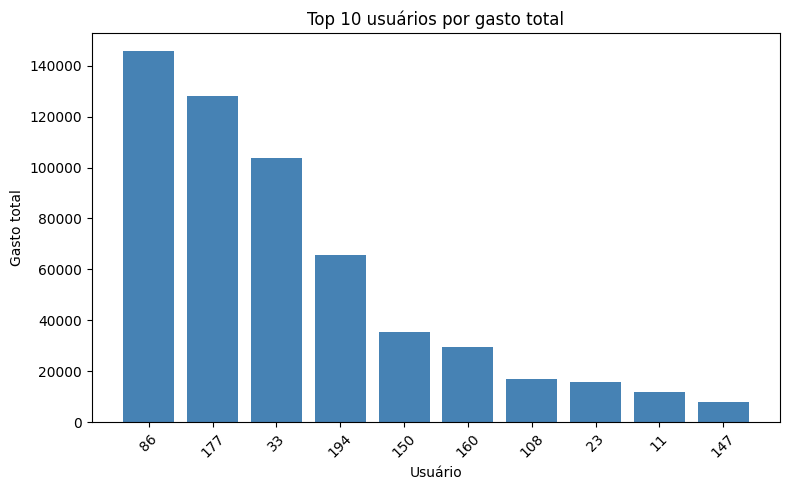

In [14]:
import matplotlib.pyplot as plt

# Ordena os usuários pelo gasto total (decrescente)
top_users = agg_users.sort_values("total_amount", ascending=False).head(10)

plt.figure(figsize=(8, 5))
plt.bar(top_users["userId"].astype(str), top_users["total_amount"], color="steelblue")

plt.title("Top 10 usuários por gasto total")
plt.xlabel("Usuário")
plt.ylabel("Gasto total")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Recap do Pipeline ETL

* **Extração (E)**

  * Fonte: [DummyJSON](https://dummyjson.com/) (API pública online).
  * Estratégia: paginação com `limit`/`skip`, *retry* em caso de falha.
  * Persistência inicial (*landing*): **um arquivo JSON por registro** (`{id}.json`).

* **Transformação (T)**

  * Leitura e **normalização** dos arquivos JSON em `pandas.DataFrame`.
  * Derivação de métricas por carrinho (`cart_items`, `cart_amount`).
  * Integração entre entidades com **join** (`userId` ↔ `id`).

* **Carga (L)**

  * Exportação para **CSV** (portabilidade e inspeção rápida).
  * Exportação para **Parquet** (colunar, otimizado para análise, quando `pyarrow` disponível).
  * Persistência em **SQLite** (área de staging), com tabelas:

    * `dim_users` (dimensão usuários)
    * `fact_carts_raw` (fato carrinhos normalizado)
    * `fact_carts_enriched` (carrinhos + dados de usuários)
    * `agg_users` (agregação por usuário)

* **Análise (A)**

  * Consultas SQL para validar o staging.
  * **Gráfico de barras** (Matplotlib) mostrando o total gasto por usuário.
  * Permite inspecionar rapidamente a **qualidade do pipeline** e gerar insights iniciais.

---

# Desafio: Criando uma Dimensão de Produtos e Analisando Consumo

A empresa fictícia **ShopX** precisa entender melhor o comportamento de compra dos seus clientes. Para isso, você deve expandir o Data Warehouse existente com base na **DummyJSON API**.

### O que precisa ser feito

1. **Extração (E):**

   * Além de usuários e carrinhos, agora também será necessário coletar **produtos** da API.
   * Cada produto tem atributos como título, preço, categoria e marca.

2. **Transformação (T):**

   * Criar uma **dimensão de produtos (`dim_products`)** a partir dos dados coletados.
   * Garantir que os atributos sejam tipados corretamente (números, strings, categorias).
   * Relacionar os produtos com os carrinhos, criando uma **tabela fato detalhada** onde cada linha representa um produto dentro de um carrinho.

3. **Carga (L):**

   * Integrar as novas tabelas ao Data Warehouse local (CSV, Parquet e SQLite).
   * Atualizar a modelagem dimensional com a nova estrela:

     * **Dimensões:** usuários, produtos.
     * **Fatos:** itens de carrinho.

4. **Análise (A):**

   * Descobrir quais são as **categorias de produtos mais vendidas** em termos de quantidade e faturamento.
   * Identificar o **ticket médio por categoria**.
   * Comparar os padrões de compra entre diferentes perfis de usuários (ex.: gênero ou faixa etária).

---

### Regras do desafio

* O pipeline deve ser **reprodutível** e não depender de dados externos além da DummyJSON.
* O Data Warehouse precisa ter ao menos **uma dimensão nova (produtos)** e **uma tabela fato granular (itens de carrinho)**.
* A análise final deve gerar **pelo menos 3 insights quantitativos** a partir do DW com visualização.

## Construa seu modelo abaixo:

## Resultado da Análise — Top Categorias por Faturamento (Exemplo de resultado)

**Dados coletados:**

* 50 usuários
* 50 carrinhos
* 50 produtos

**Consulta OLAP:** gasto total agregado por categoria de produto.

| Categoria           | Total de Itens | Faturamento Total |
| ------------------- | -------------- | ----------------- |
| furniture           | 9              | 12,699.91         |
| fragrances          | 14             | 1,059.86          |
| home-decoration     | 22             | 639.78            |
| groceries           | 99             | 410.31            |
| beauty              | 17             | 193.83            |
| kitchen-accessories | 8              | 59.92             |